In [83]:
import xml.etree.cElementTree
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import subprocess
import os
%matplotlib inline
from IPython.display import clear_output


In [154]:
## Generate input file:

D2R = np.pi/180.

evec = pow(10,np.linspace(4,7,24))
print evec

thicknesses = [0.05, 0.1, 0.5, 1];
material = "Al"
filename = "energy_sweep.mac"
n_runs = 50000

# histogram settings:
hmin = 1e4 #ev
hmax = 2e7 #ev
nh   = 128

origin = [0,0,10]
direction=[0,0,-1]
with open(filename,'w') as file:
    file.write("# Autogenerated by energy_sweep.ipynb\n")
    # Preliminary setup:

# Disable all the chatter
    file.write('/run/initialize\n')
    file.write('/control/verbose 0\n')
    file.write('/run/verbose 0\n')
    file.write('/event/verbose 0\n')
    file.write('/tracking/verbose 0\n\n')
    
    # General particle source:

    file.write('/gps/particle gamma\n')
#     file.write('/gps/polarization 0 0 0\n')
    file.write('/gps/pos/type Plane\n')
    file.write('/gps/pos/shape Circle\n')
    file.write('/gps/pos/radius 1. mm\n\n')
    
    file.write('/run/setCut 0.01 mm\n\n')
    
    file.write("/gps/position %2.4g %2.4g %2.4g cm\n"%(origin[0], origin[1], origin[2]))
    file.write("/gps/direction %2.4g %2.4g %2.4g cm\n"%(direction[0], direction[1], direction[2]))


#     file.write('/analysis/setHistoDirName photon_sweep_histograms\n\n')
    # Histograms:
#     file.write('/analysis/setHistoDirName photon_sweep_histograms\n')
    file.write('/analysis/h1/create "h1" "Source energy, ev" %d %d %d eV log10\n'%(nh, hmin, hmax))
    file.write('/analysis/h1/create "h2" "Detected energy, ev" %d %d %d eV log10\n'%(nh, hmin, hmax))
    file.write('/analysis/h1/create "h3" "Window energy, ev" %d %d %d eV log10\n'%(nh, hmin, hmax))
    file.write('/analysis/h1/create "h4" "Entering energy, ev" %d %d %d eV log10\n'%(nh, hmin, hmax))

    file.write('\n\n');
    
    file.write('/payload/setWindowMat %s\n'%material)
    file.write('/payload/update\n\n')
    
    for thickness in thicknesses:
        file.write('/payload/setWindowThick %2.1g mm\n'%thickness)
        file.write('/payload/update\n\n')
        
        for energy in evec:
            file.write('# %d eV energy, %2.1g mm thickness\n'%(energy, thickness))
            file.write('/gps/energy %d eV\n'%energy)
            file.write("/analysis/setFileName energy_sweep_%d_ev_%2.0e_mm\n"%(energy, thickness))
            file.write("\n")
            file.write("/run/beamOn %d\n"%n_runs)
            file.write("\n")

[   10000.            13503.1403787     18233.48000868    24620.92401495
    33245.97932271    44892.51258219    60618.98993498    81854.67307069
   110529.5141126    149249.55450518   201533.76859417   272133.87683753
   367466.19407367   496194.76030029   670018.75035096   904735.72423493
  1221677.34899679  1649648.07409802  2227542.95199956  3007882.5180431
  4061585.98837698  5484416.57612102  7405684.69226244 10000000.        ]


In [10]:
def load_histo_file(filename):    
    hists = dict()
    axes  = dict()
    underflows = dict()
    overflows = dict()
    
    e = xml.etree.cElementTree.parse(filename).getroot()

    for hist in e.findall('histogram1d'):
        axis_info = hist.findall('axis')[0].attrib
        print axis_info
        bin_vals = pow(10,np.linspace(float(axis_info['min']), float(axis_info['max']), int(axis_info['numberOfBins'])))
#         bin_vals = np.linspace(float(axis_info['min']), float(axis_info['max']), int(axis_info['numberOfBins']))


        title = hist.attrib['title']

    #     print bin_vals
        cur_hist = np.zeros_like(bin_vals)
        for cell in hist.findall('data1d')[0]:
            try:
                binN=int(cell.attrib['binNum'])
                binH=int(cell.attrib['height'])
                cur_hist[binN] = binH
            except:
                if 'UNDERFLOW' in cell.attrib['binNum']:
                    underflows[title] = int(cell.attrib['height'])
                if 'OVERFLOW' in cell.attrib['binNum']:
                    overflows[title] = int(cell.attrib['height'])
        hists[title] = cur_hist
        axes[title]  = bin_vals

        print title, " has", np.sum(cur_hist), "values"
    return hists, axes, underflows, overflows




loading 483293 ev
{'max': '7', 'direction': 'x', 'numberOfBins': '100', 'min': '3'}
Source energy, ev  has 50000.0 values
{'max': '7', 'direction': 'x', 'numberOfBins': '100', 'min': '3'}
Detected energy, ev  has 37380.0 values
{'max': '7', 'direction': 'x', 'numberOfBins': '100', 'min': '3'}
Window energy, ev  has 49999.0 values
{'max': '7', 'direction': 'x', 'numberOfBins': '100', 'min': '3'}
Entering energy, ev  has 37387.0 values
-------
loading 695193 ev
{'max': '7', 'direction': 'x', 'numberOfBins': '100', 'min': '3'}
Source energy, ev  has 50000.0 values
{'max': '7', 'direction': 'x', 'numberOfBins': '100', 'min': '3'}
Detected energy, ev  has 43503.0 values
{'max': '7', 'direction': 'x', 'numberOfBins': '100', 'min': '3'}
Window energy, ev  has 49999.0 values
{'max': '7', 'direction': 'x', 'numberOfBins': '100', 'min': '3'}
Entering energy, ev  has 43515.0 values
-------
loading 1e+06 ev
{'max': '7', 'direction': 'x', 'numberOfBins': '100', 'min': '3'}
Source energy, ev  has 50

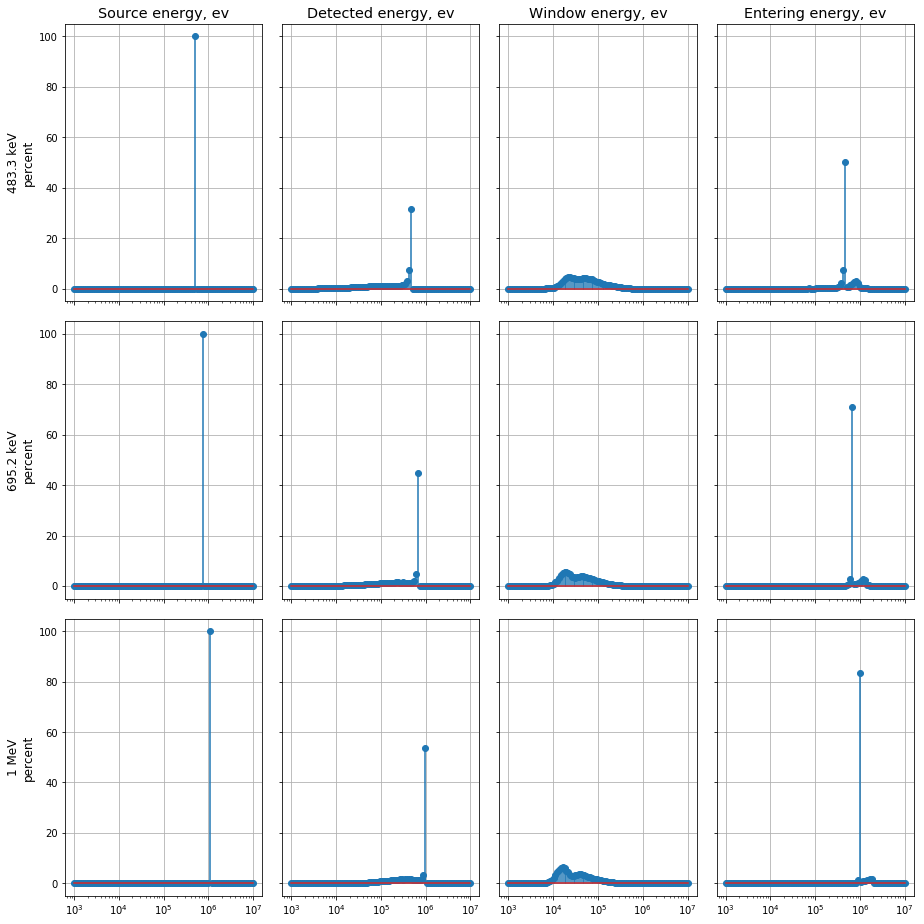

In [122]:
# Plot the results:
# --------------- Latex Plot Beautification --------------------------
fig_width = 12
fig_height = 12
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 12,
          'font.size': 12,
          'legend.fontsize': 12,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


# d = os.listdir('.')
# files = [x for x in d if x.startswith('photon_sweep') and x.endswith(".xml")]
# print files

keylist = ['Source energy, ev', 'Detected energy, ev', 'Window energy, ev','Entering energy, ev']
fig, ax = plt.subplots(len(evec[-3:]), len(keylist), sharex=True, sharey=True)

thickness=0.01
for energy_ind, energy in enumerate(evec[-3:]):
    print "loading %g ev"%energy
#     filename = "energy_sweep_%d_ev.xml"%(energy)
    filename = 'energy_sweep_%d_ev_%2.0e_mm.xml'%(energy, thickness)


    hists, axes, underflows, overflows = load_histo_file(filename)
    print "-------"
    
    runtotal = np.sum(hists['Source energy, ev'])

    for k_ind, key in enumerate(keylist):
        ax[energy_ind, k_ind].stem(axes[key], 100.0*hists[key]/runtotal,zorder=100, alpha=0.7)
        ax[energy_ind, k_ind].set_ylabel('counts')
        ax[energy_ind, k_ind].grid('on', zorder=0)

        ax[energy_ind, k_ind].set_xscale('log')
        ax[0, k_ind].set_title(key)
        ax[energy_ind, k_ind].set_ylabel('')
    
    if energy < 1e6:
        ax[energy_ind, 0].set_ylabel('%1.4g keV\npercent'%(energy/1000.))
    elif energy >= 1e6:
        ax[energy_ind, 0].set_ylabel('%1.4g MeV\npercent'%(energy/1000./1000.))

#     # Set yscales:
#     maxy_0 = 0
#     maxy_1 = 0
#     for x in range(len(angles)):
#         maxy_0 = max(maxy_0, ax[x,0].get_ylim()[1])
#         maxy_0 = max(maxy_0, ax[x,2].get_ylim()[1])
#         maxy_1 = max(maxy_1, ax[x,1].get_ylim()[1])
#         maxy_1 = max(maxy_1, ax[x,3].get_ylim()[1])

#     maxy_0 = np.ceil(maxy_0/10)*10
#     maxy_1 = np.ceil(maxy_1/10)*10
#     for x in range(len(angles)):
#         ax[x,0].set_ylim([0,maxy_0])
#         ax[x,2].set_ylim([0,maxy_0])
# #         ax[x,1].set_ylim([0,maxy_1])
# #         ax[x,3].set_ylim([0,maxy_1])

    fig.tight_layout()
#     fig.subplots_adjust(top=0.9)
#     fig.suptitle('Photon response vs angle -- %d keV'%(energy/1000.))
#     figname = 'photon_response_%1.0e_ev.png'%energy
#     fig.savefig(figname, dpi=300)




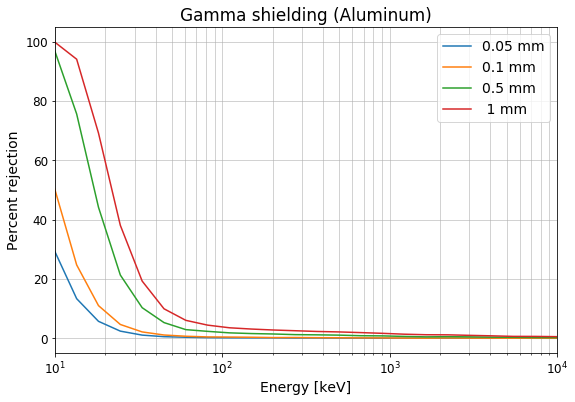

In [156]:
# --------------- Latex Plot Beautification --------------------------
fig_width = 8
fig_height = 5
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

fig, ax = plt.subplots(1,1)

# directory = 'electron screening, tungsten window'
directory=''
for thickness in [0.05, 0.1, 0.5, 1]:
    absorption_vec = []
    for energy_ind, energy in enumerate(evec):

        print "loading %g ev"%energy
        filename = os.path.join(directory,'energy_sweep_%d_ev_%2.0e_mm.xml'%(energy, thickness))

        hists, axes, underflows, overflows = load_histo_file(filename)
        print "-------"

        runtotal = np.sum(hists['Source energy, ev'])
#         window_absorption = 100.*(max(hists['Window energy, ev']) + max(hists['Backscattered energy, ev']))/runtotal
        window_absorption =100. - 100.*(max(hists['Entering energy, ev']))/runtotal
#         print window_absorption
        absorption_vec.append(window_absorption)
        clear_output(wait=True)



    ax.plot(evec/1000., absorption_vec, label='%2.3g mm'%(thickness))
    

ax.set_xscale('log')
ax.set_ylabel('Percent rejection')
ax.set_xlabel('Energy [keV]')
ax.set_ylim([-5, 105])
ax.set_xlim([1e1, 1e4])
ax.grid('on',which='both', alpha=0.7)
ax.legend()
ax.set_title('Gamma shielding (Aluminum)')

fig.savefig('Gamma shielding (Aluminum).pdf')



#     print window_absorption

#     for k_ind, key in enumerate(keylist):
#         ax[energy_ind, k_ind].stem(axes[key], 100.0*hists[key]/runtotal,zorder=100, alpha=0.7)
#         ax[energy_ind, k_ind].set_ylabel('counts')
#         ax[energy_ind, k_ind].grid('on', zorder=0)

#         ax[energy_ind, k_ind].set_xscale('log')
#         ax[0, k_ind].set_title(key)
#         ax[energy_ind, k_ind].set_ylabel('')
    
#     if energy < 1e6:
#         ax[energy_ind, 0].set_ylabel('%1.4g keV\npercent'%(energy/1000.))
#     elif energy >= 1e6:
#         ax[energy_ind, 0].set_ylabel('%1.4g MeV\npercent'%(energy/1000./1000.))



loading histo
{'max': '7', 'direction': 'x', 'numberOfBins': '100', 'min': '3'}
Source energy, ev  has 500000.0 values
{'max': '7', 'direction': 'x', 'numberOfBins': '100', 'min': '3'}
Detected energy, ev  has 188521.0 values
{'max': '7', 'direction': 'x', 'numberOfBins': '100', 'min': '3'}
Window energy, ev  has 499811.0 values
-------


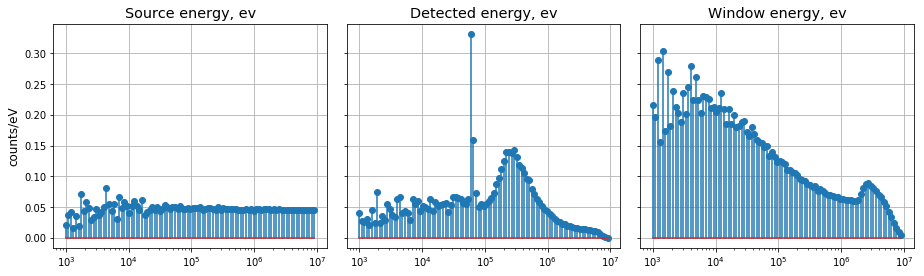

In [45]:
# Plot the output of 'run.mac'  (distribution of energies)

# Plot the results:
# --------------- Latex Plot Beautification --------------------------
fig_width = 12
fig_height = 3
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 12,
          'font.size': 12,
          'legend.fontsize': 12,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


keylist = ['Source energy, ev', 'Detected energy, ev', 'Window energy, ev']
fig, ax = plt.subplots(1, len(keylist), sharex=True, sharey=True)


print "loading histo"
filename = "histo.xml"
hists, axes, underflows, overflows = load_histo_file(filename)
print "-------"

for k_ind, key in enumerate(keylist):
    ax[k_ind].stem(axes[key][:-1], hists[key][:-1]/np.diff(axes[key]),zorder=100, alpha=0.7)
    ax[k_ind].set_ylabel('counts')
    ax[k_ind].grid('on', zorder=0)

    ax[k_ind].set_xscale('log')
    ax[k_ind].set_title(key)
    ax[k_ind].set_ylabel('')

ax[0].set_ylabel('counts/eV')



fig.tight_layout()




In [64]:
# for energy_ind, energy in enumerate(evec):
#     print "%1.4g\n"%(energy/1000.)
runtotal = np.sum(hists['Source energy, ev'])
print runtotal

100000.0


[   1000.            1438.44988829    2069.13808111    2976.35144163
    4281.33239872    6158.48211066    8858.6679041    12742.74985703
   18329.80710832   26366.5089873    37926.90190732   54555.94781169
   78475.99703515  112883.78916847  162377.67391887  233572.14690901
  335981.82862838  483293.02385718  695192.79617756 1000000.        ]
